### Research Questions:

1. What Is the Distribution of Accidents and Fatal Accidents by Month, Day of the Week, and Part of the Day? <br>
2. Which Type of Accident Is the Most Fatal? <br>
3. Which Environmental Conditions Increase the Probability of Fatal Accidents? <br>
4. Can I Predict the Number of Accidents Based on Time, Date, and Environmental Conditions? <br>

## 1. Data Cleaning and Proccessing 

In the next section I imported the data and processed it using the following steps:
1. Remove duplicates <br>
2. Handle missing values – There were no missing values.
3. Validate data types
4. Identify and remove outliers – Outliers were detected using the IQR method with a threshold of 3 instead of 1.5 for less aggressive removal, then filtered out.

5. Feature engineering – Converted crash_date to extract the year and date, removed the original column, and categorized crash_hour into different parts of the day.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.options.mode.copy_on_write = True
sns.set(rc={'figure.figsize':(10,5)}, style='whitegrid') 
plt.rcParams['axes.grid'] =False
# plt.rcParams.keys()
pd.set_option('display.max_columns', 50)
df= pd.read_csv(r'traffic_accidents.csv')

### 1.1 Number of Duplicated values  

In [2]:
size_before = df.shape[0]
df_without_dups = df.drop_duplicates()
final_size = size_before - df_without_dups.shape[0]
print(f'The number of duplicates in the dataset is {final_size}')

The number of duplicates in the dataset is 31


### 1.2 Dealing with missing values

In [3]:
print(df.isna().sum().sum())
print('There\'s no missing values in the dataset')

0
There's no missing values in the dataset


### 1.3 Dtype check 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

### 1.4 Extracted the Date and Year from the crash_date column into new columns.

In [5]:
df['year'] = pd.to_datetime(df.crash_date,errors='coerce',format='%m/%d/%Y %I:%M:%S %p').dt.year
df['date'] = pd.to_datetime(df.crash_date,errors='coerce',format='%m/%d/%Y %I:%M:%S %p').dt.date
df = df.drop(['crash_date'],axis=1)
def hour_to_day_part(hour):
    if hour in range(6,12):
        return "Morning"
    elif hour in range(12,18):
        return "Afternoon"
    elif hour in range(18,24):
        return "Evening"
    else:
        return "Night"
df['day_part'] = df['crash_hour'].apply(hour_to_day_part)



### 1.5 Handle Outliers

In [6]:
def is_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    IQR = IQR.replace(0,1) 

    return (df < (Q1 - 3 * IQR)) | (df > (Q3 + 3 * IQR))
is_outliers(df.select_dtypes(exclude='object')).sum().sum()
# row before removing outliers
print(f'Rows before removing outliers: {df.shape[0]}')
# removing outliers
df = df[~is_outliers(df.select_dtypes(exclude='object')).any(axis=1)]
# row after removing outliers
print(f'Rows after removing outliers: {df.shape[0]}')


Rows before removing outliers: 209306
Rows after removing outliers: 205692


## EDA

### 1. What Is the Distribution of Accidents and Fatal Accidents by Month, Day of the Week, and Part of the Day?

#### Distribution of Accidents by Year
Insights and Explanation:

What This Chart Shows: <br>

This dual-axis bar chart displays total accidents (blue, left y-axis) and fatal accidents (red, right y-axis) for each year from 2018 to 2024. <br>
Total accidents show fluctuations over the years, with a drop in 2020 followed by a recovery. <br>
Fatal accidents have a similar trend but show a notable increase in 2020 and 2021. <br>
Hypothesis: The drop in total accidents in 2020 was likely due to COVID-19 lockdowns reducing traffic. However, fatal accidents did not drop proportionally, possibly due to riskier driving behavior on emptier roads. <br>

Insights: <br>

Total accidents decreased significantly in 2020, likely due to lockdown restrictions limiting vehicle movement. <br>
Fatal accidents remained high in 2020 and 2021 despite lower overall accidents, suggesting an increase in speeding or reckless driving. <br>
The accident rate rebounded in 2021 and stabilized in subsequent years. <br>


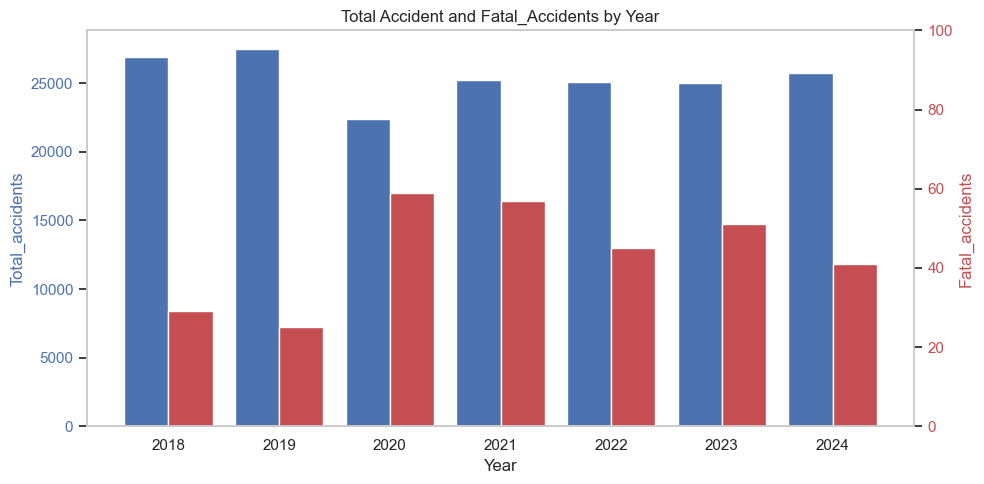

In [7]:

range_years =df[(df['year']>=2018 )& (df['year']<=2024)]
years = range_years['year'].sort_values().unique().tolist()
injuries =  range_years.groupby(['year'],as_index=False).agg({'injuries_fatal':['sum','count']}).reset_index()
fatal_acidents = injuries.iloc[:,2]
total_acidents = injuries.iloc[:,3]

# Sample DataFrame for demonstration
data = {
    'year': years,
    'Total_accidents': total_acidents,
    'Fatal_accidents': fatal_acidents
}
df2 = pd.DataFrame(data)

# Create a bar plot with two y-axes
fig, ax1 = plt.subplots()

# Plot total incidents on the primary y-axis
ax1.bar(df2['year'] - 0.2, df2['Total_accidents'], width=0.4, label='Total_accidents', color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total_accidents', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(df2['year'] + 0.2, df2['Fatal_accidents'], width=0.4, label='Fatal_accidents', color='r')
ax2.set_ylabel('Fatal_accidents', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 100)

# Set the title and show the plot
plt.title('Total Accident and Fatal_Accidents by Year')
fig.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

### Distribution of Accidents by Month

This dual-axis bar chart compares total accidents (blue, left y-axis) and fatal accidents (red, right y-axis) for each month. <br>
The right y-axis shows fatal accidents on a smaller scale, emphasizing their relative frequency. <br>
Hypothesis:<br> 
Accidents peak in September and October due to seasonal changes, increased travel, and hazardous weather conditions. <br>

Insights: <br>
Total accidents are highest in September and October. <br>
#אולי במזג אוויר חורפי מספר התאונות הקטלניות קטן יותר כי אנשים יוצאים פחות מהבית 




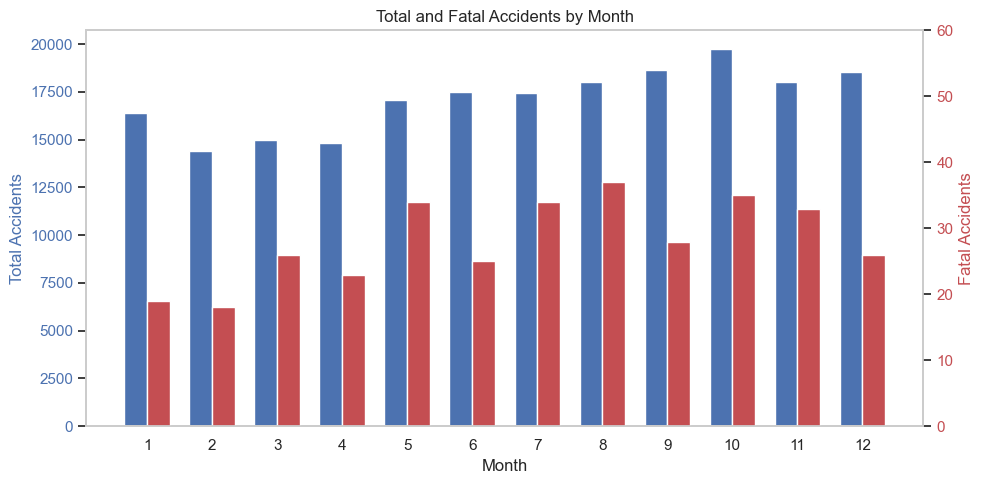

In [8]:
injuries = df.groupby(['crash_month'], as_index=False).agg({'injuries_fatal': ['sum', 'count']})
fatal_accidents = injuries['injuries_fatal']['sum']
Total_accidents = injuries['injuries_fatal']['count']

fig, ax1 = plt.subplots()

bar_width = 0.35  # Width of the bars
x = np.arange(len(injuries['crash_month']))  # The label locations

# Plot total incidents on the primary y-axis
ax1.bar(x - bar_width/2, Total_accidents, bar_width, label='Total Incidents', color='b')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Accidents', color='b')
ax1.tick_params(axis='y', labelcolor='b')


# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, fatal_accidents, bar_width, color='r')
ax2.set_ylabel('Fatal Accidents', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 60)

# Set the x-ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(injuries['crash_month'])

plt.title('Total and Fatal Accidents by Month')
fig.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


#### Accidents by day of week and part of the day:

This grouped bar chart presents the number of accidents for each day of the week, categorized by time of day (morning, afternoon, evening, night). <br>
The afternoon has the highest accident frequency across all days. <br>
Hypothesis: <br> Higher accident rates in the afternoon, especially on Fridays result from increased traffic, fatigue, and risky driving behaviors. <br>

Insights: <br>
The highest accident rates occur in the afternoon across all days, with peaks on Fridays. <br>
This suggests that rush-hour traffic, fatigue, and leisure activities contribute to accidents. <br>
 ניתן לראות שיש אבסולוטית יותר תאונות בימי המנוחה (ראשון ושבת בשעות הלילה כי יש יותר תנועה על הכביש אנשים חוזרים ממסיבות וכו') 

In [9]:
# Correct mapping of numbers to weekday names (assuming 1 = Sunday)
weekday_mapping = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}

# Apply the mapping to the 'crash_day_of_week' column
df["crash_day_of_week"] = df["crash_day_of_week"].map(weekday_mapping)

# Define the correct order of weekdays
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


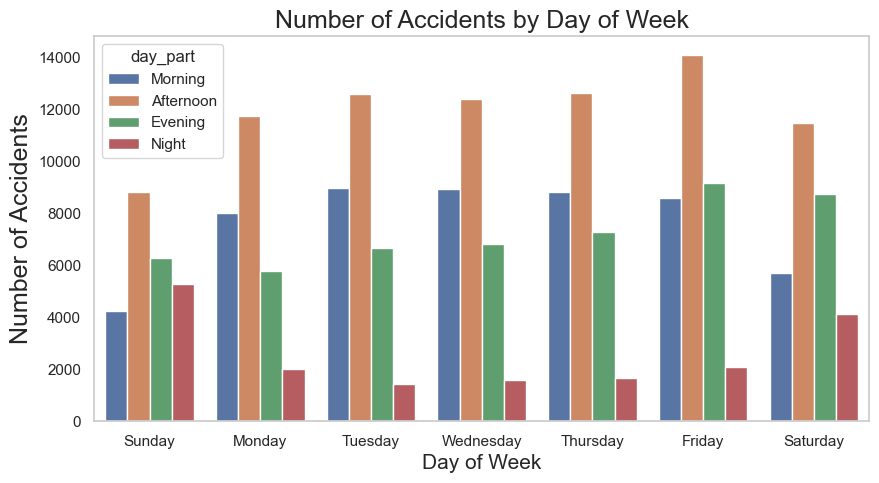

In [36]:

# Plot with updated labels
sns.countplot(
    data=df, x="crash_day_of_week", order=weekday_order,
    hue='day_part', hue_order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Number of Accidents by Day of Week', fontsize=18)
plt.ylabel('Number of Accidents', fontsize=18)
plt.xlabel('Day of Week', fontsize=15)

plt.show()


### 2.Which Type of Accident is the Most Fatal? 

What The Chart below Shows: <br>

This bar chart ranks different crash types by their percentage contribution to fatal accidents. <br>
Pedestrian crashes have the highest fatality rate, while rear-end collisions have the lowest. <br>
Hypothesis: Pedestrian accidents and fixed-object collisions have the highest fatality rates due to lack of protection and high-impact crashes. <br>

Insights: <br>

Pedestrian crashes are the deadliest, followed by fixed-object collisions. <br>
Rear-end crashes have a much lower fatality rate, likely due to lower speeds and vehicle safety features. <br>

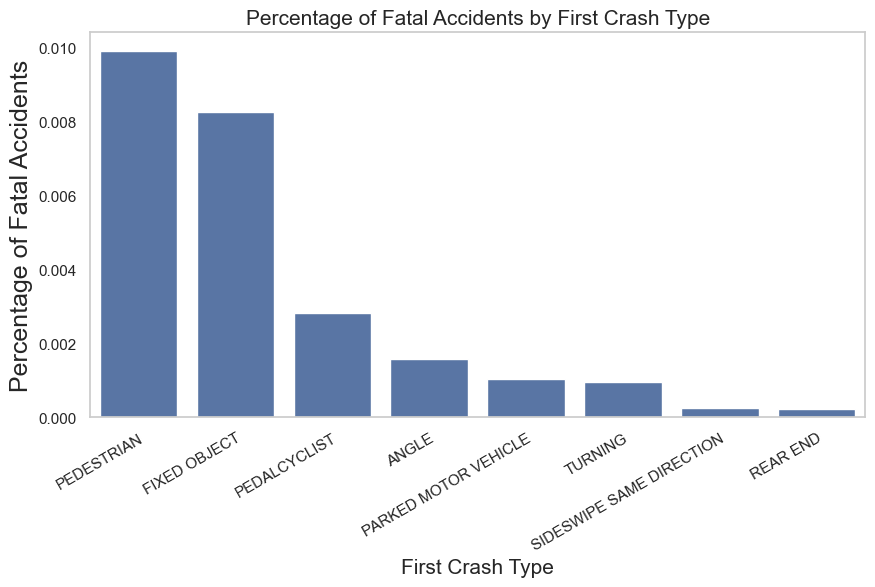

In [39]:
accident_object_type = df.first_crash_type.value_counts().index[:8].to_list()
fatal_counts = df[df.first_crash_type.isin(accident_object_type)].groupby('first_crash_type')['most_severe_injury'].apply(lambda x: (x == 'FATAL').mean())
sns.barplot(x=fatal_counts.index, y=fatal_counts, order=fatal_counts.sort_values(ascending=False).index)
plt.title('Percentage of Fatal Accidents by First Crash Type' , fontsize=15)
plt.ylabel('Percentage of Fatal Accidents', fontsize=18)
plt.xlabel('First Crash Type', fontsize=15)

plt.xticks(rotation=30, ha='right', rotation_mode='anchor')

plt.show()

### 3 Which Environmental Conditions Increase the Probability of Fatal Accidents?
#### 3.1 Light Conditions
What The Chart Below Shows: <br>

This bar chart displays the fatal accident rate under different lighting conditions. <br>
Fatality rates are lowest during daylight and dawn, while darkness has the highest fatality rate. <br>
Hypothesis: Poor visibility at night increases the likelihood of severe accidents due to slower reaction times and higher impact speeds. <br>

Insights: <br>

Fatal accidents are more likely to occur in darkness, even on lighted roads. <br>
The fatality rate during dusk is significantly higher than in daylight, possibly due to rapidly changing lighting conditions. <br>

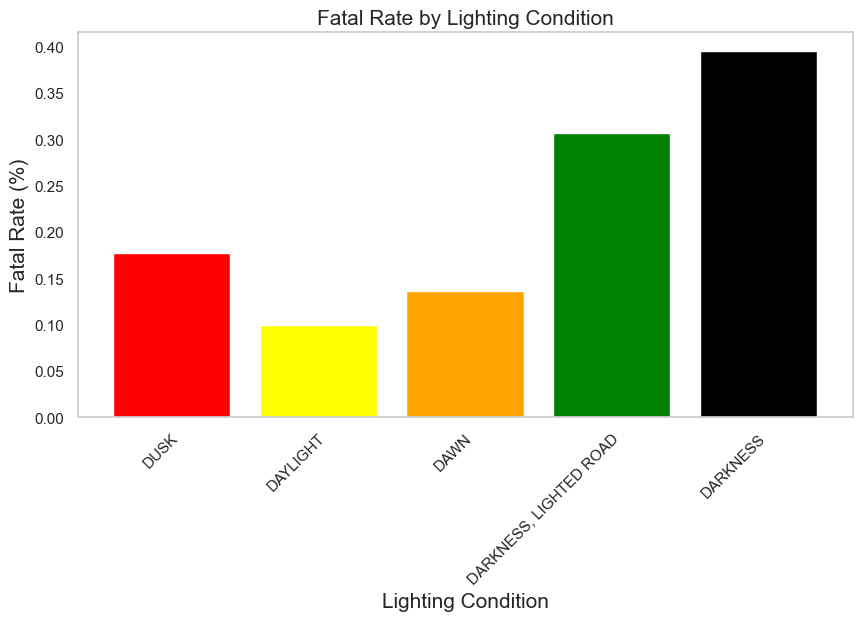

In [42]:
df_lighting_condintion = df.groupby('lighting_condition',as_index=False).agg(sum_injuries_fatal=('injuries_fatal', 'sum'), count_injuries_fatal=('injuries_fatal', 'count'))
df_lighting_condintion['fatal_rate'] = (df_lighting_condintion['sum_injuries_fatal'] / df_lighting_condintion['count_injuries_fatal'] ) * 100

fig, ax = plt.subplots()
ax.bar(df_lighting_condintion['lighting_condition'].head(5).sort_index(ascending=False), df_lighting_condintion['fatal_rate'].head(5).sort_index(ascending=False), color= ['red','yellow','orange', 'green','black'])
ax.set_title('Fatal Rate by Lighting Condition', fontsize=15)
ax.set_xlabel('Lighting Condition', fontsize=15)
ax.set_ylabel('Fatal Rate (%)', fontsize=15)
plt.xticks(rotation=45,rotation_mode='anchor',ha='right')
plt.show()




#### 3.2 Weather Conditions 

This bar chart shows the fatal accident rate under different weather conditions. <br>
The fatality rate is nearly the same for clear, rainy, and overcast conditions but significantly lower in snowy conditions. <br>
Hypothesis: Drivers adjust their behavior in snow (slower speeds, increased caution), reducing the fatality rate despite hazardous conditions. <br>

Insights: <br>

Clear weather has just as many fatal accidents as rainy and overcast weather, suggesting driver behavior plays a more significant role than weather alone. <br>
Snow-related accidents are less fatal, likely due to reduced vehicle speeds and increased caution. <br>

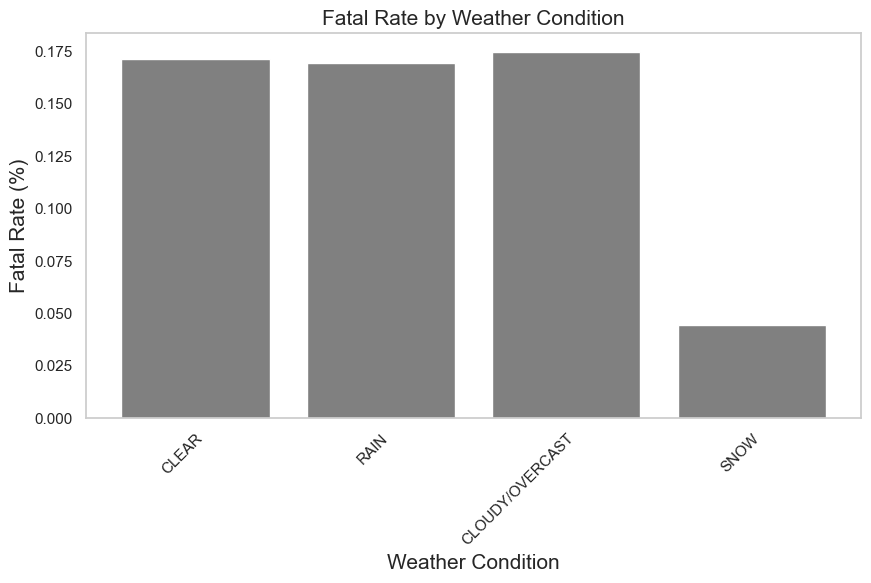

In [43]:
df_weather_condition = df.groupby('weather_condition', as_index=False).agg(
    sum_injuries_fatal=('injuries_fatal', 'sum'),
    count_injuries_fatal=('injuries_fatal', 'count')
).sort_values(by='count_injuries_fatal', ascending=False).head(4)
df_weather_condition['fatal_rate'] = df_weather_condition['sum_injuries_fatal'] / df_weather_condition['count_injuries_fatal'] * 100

fig, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'orange']
ax.bar(df_weather_condition['weather_condition'], df_weather_condition['fatal_rate'], color='grey')
ax.set_title('Fatal Rate by Weather Condition', fontsize=15)
ax.set_xlabel('Weather Condition', fontsize=15)
ax.set_ylabel('Fatal Rate (%)', fontsize=15)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.show()


#### 3.3 Road Conditions
 

This bar chart compares fatal accident rates on roads with and without defects. <br>
Roads with defects have a noticeably higher fatality rate. <br>
Hypothesis: Poor road conditions (potholes, uneven surfaces, poor signage) contribute to loss of control and more severe crashes. <br>

Insights: <br>

Road defects significantly increase the likelihood of fatal accidents. <br>
Drivers may struggle to react quickly to road defects, leading to more severe crashes. <br>

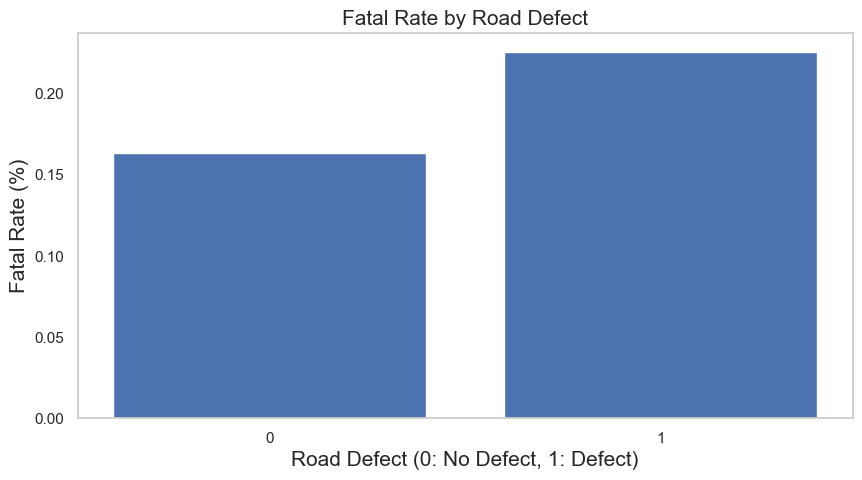

In [44]:

df['road_defect_bynary'] = 0
df.loc[(df['road_defect'] != 'NO DEFECTS') & (df['road_defect'] != 'UNKNOWN'), 'road_defect_bynary'] = 1
df_road_defect_rate = df.groupby('road_defect_bynary').agg(sum_injuries_fatal=('injuries_fatal', 'sum'), count_injuries_fatal=('injuries_fatal', 'count'))

df['road_defect_bynary'] = 0
df.loc[(df['road_defect'] != 'NO DEFECTS') & (df['road_defect'] != 'UNKNOWN'), 'road_defect_bynary'] = 1

df_road_defect_rate['fatal_rate'] = df_road_defect_rate['sum_injuries_fatal'] / df_road_defect_rate['count_injuries_fatal'] * 100


# Plotting the bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['0','1'], df_road_defect_rate['fatal_rate'],)
ax.set_title('Fatal Rate by Road Defect', fontsize=15)
ax.set_xlabel('Road Defect (0: No Defect, 1: Defect)', fontsize=15)
ax.set_ylabel('Fatal Rate (%)', fontsize=15)
plt.xticks(rotation=0)
plt.show()


### 4. Can I Predict the Number of Accidents Based on Time, Date, and Environmental Conditions?
#### Built a Linear Regression Model to Estimate the Occurrence of Accidents

The model below captures general trends but struggles with extreme values, making it more reliable for moderate predictions. It was chosen for its simplicity, efficiency, and interpretability, making it suitable for trend analysis rather than precise forecasting.

we built the model by the following steps:
1 define the depndent variable: number of accidents
2. define the independent variables : Weekday, part of the day and weather condition 
3.Data processing: 
    a. applied a groupby operation on the dataset using the independent variable.
    b. normalized the dependent variable 
    c. split the data to train and test subsets 
4. we train and evaluate a linear model


In [15]:
# label 1 the hours that are between 6 am and 8 pm and 0 the rest 
df['day_or_night'] = df['crash_hour'].apply(lambda x: 1 if((x>6) &(x<20)) else 0)

# Aggregate data: Get the most common weather condition and count per date
df_model = df.groupby(['date', 'day_or_night'], as_index=False).agg(
    weather_condition=('weather_condition', lambda x: x.mode()), 
    count=('weather_condition', 'count')
)

# # Keep only rows where the "weather_condition" is one of ['CLEAR', 'RAIN', 'SNOW']
# and the accident count is at least 2, ensuring we focus on relevant weather conditions with sufficient occurrences
df_model = df_model[df_model['weather_condition'].isin(['CLEAR', 'RAIN', 'SNOW']) & (df_model['count'] >=2)]
# extract the weekday from the date column
df_model.loc[:,'WEEKDAY'] = pd.to_datetime(df_model['date']).dt.dayofweek

# Convert the "weather_condition" and "WEEKDAY" columns into numeric values for modeling and merge them into the dataset
df_numeric_model = pd.concat([pd.get_dummies(df_model['weather_condition'],dtype=int),pd.get_dummies(df_model['WEEKDAY'],dtype=int)],axis=1)

df_numeric_model['day_or_night'] = df_model['day_or_night']
# normalize the count column
df_numeric_model.loc[:,'count_normalized'] =(df_model['count'] /df_model['count'].max()).round(2)
df_numeric_model


,CLEAR,RAIN,SNOW,0,1,2,3,4,5,6,day_or_night,count_normalized
6,1,0,0,0,1,0,0,0,0,0,1,0.02
9,1,0,0,0,0,0,0,1,0,0,1,0.02
15,1,0,0,0,0,0,0,1,0,0,1,0.04
16,1,0,0,0,0,0,0,0,1,0,1,0.02
18,1,0,0,1,0,0,0,0,0,0,1,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
6857,1,0,0,0,0,1,0,0,0,0,1,0.49
6858,1,0,0,0,0,0,1,0,0,0,0,0.10
6859,1,0,0,0,0,0,1,0,0,0,1,0.35
6860,1,0,0,0,0,0,0,1,0,0,0,0.08


In [16]:

# Define features (X) and target (y)
x = df_numeric_model.drop(columns=['count_normalized'])  # Drop the target column
y = df_numeric_model['count_normalized']  # Target variable

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)




In [17]:
# Ensure all column names are strings
x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)
# Create a linear regression model and fit it to the training data
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

In [18]:
# Generate sample 
sample_accidents = np.random.choice(y_test.index, size=100, replace=False)

# Create samples for true and predicted values
y_test_sample = y_test.loc[sample_accidents]
y_pred_sample = pd.Series(y_pred, index=y_test.index).loc[sample_accidents]


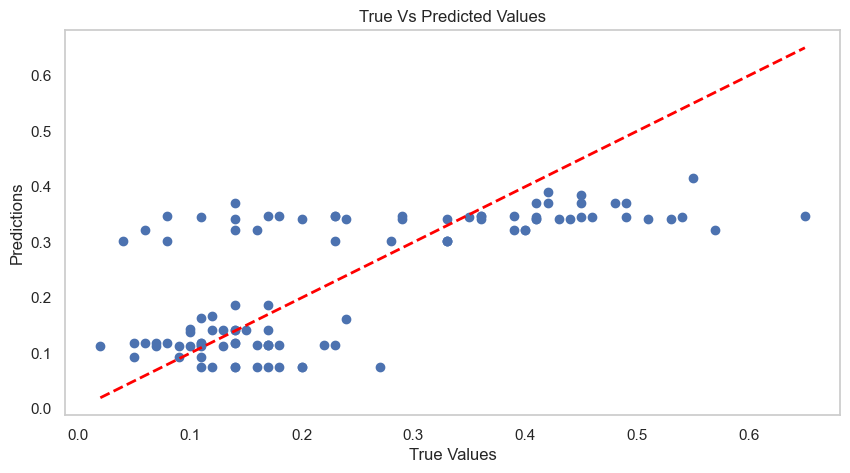

In [19]:

# Scatter plot of true vs predicted values
plt.scatter(y_test_sample, y_pred_sample)

# Generate y-axis ticks
y_ticks = np.unique(np.round(np.linspace(y_test_sample.min(), y_test_sample.max(), 10), 1))

# Plot the reference line
plt.plot([y_test_sample.min(), y_test_sample.max()], [y_test_sample.min(), y_test_sample.max()], color='red', linestyle='--', linewidth=2)



# Set axis labels and title
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Vs Predicted Values')

# Display the plot
plt.show()

In [20]:
# Create a DataFrame to store the coefficients of the model
coeff_df = pd.DataFrame({'Feature': x_test.columns, 'Coefficient': linear_model.coef_})
coeff_df.Coefficient = coeff_df.Coefficient.map(lambda x:f'{x:.2f}')
coeff_df

,Feature,Coefficient
0,CLEAR,-0.02
1,RAIN,0.02
2,SNOW,0.00
3,0,-0.02
4,1,0.00
5,2,0.01
6,3,0.01
7,4,0.03
8,5,0.00
9,6,-0.04


In [21]:
# Calculate the Mean Squared Error and R² Score
print(f"Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred)}\nR² Score: {r2_score(y_test, y_pred)}")

Root Mean Squared Error: 0.11480791816854788
R² Score: 0.4740863804748846


to include in the readme file <br>

This project analyzes traffic accident data to identify key factors influencing accident severity. 
<br>The dataset includes variables related to weather conditions, lighting, road defects, and accident severity levels.
<br>Key findings show that nighttime and poorly light roads significantly increase fatality rates, while road defects contribute to higher accident severity.<br> Weather conditions like rain and overcast skies have a notable impact, whereas snow conditions show lower fatality rates, possibly due to cautious driving.<br> The predictive model captures general trends but struggles with extreme values, making it more suitable for trend analysis than precise forecasting. <br>Recommendations include enhancing road lighting, improving maintenance, and increasing driver awareness in hazardous conditions to reduce accident fatalities.